# Predictive Modelling of Player Performances in UEFA Champions League

For this project, I have chosen a dataset from Kaggle.

As I am inrested in football particularly, I have chosen a dataset related to UEFA Champions League.

Below is the data details:

https://www.kaggle.com/datasets/azminetoushikwasi/ucl-202122-uefa-champions-league/data

## About Dataset
### Context

This dataset contains all the player stats of UEFA Champions League season 2021-22 .

### About UEFA Champions League

The UEFA Champions League is an annual club football competition organised by the Union of European Football Associations and contested by top-division European clubs, deciding the competition winners through a round robin group stage to qualify for a double-legged knockout format, and a single leg final.

#### Content:

attacking.csv;

attempts.csv; 

defending.csv; 

disciplinary.csv; 

distributon.csv; 

goalkeeping.csv; 

key_stats.csv


Among these 7 datasets, I have chosen **key_states.csv** dataset.

Below are the available columns from the dataset:

* **player_name:** Player's name
* **club:** Name of the player's club
* **position:** Position of the player (example: Forward)
* **minutes_played:** Total minutes played by a player in this competition
* **match_played:** Number of matches played
* **goals:** Number of goals scored
* **assists:** Number of assists
* **distance_covered:** Overall distance covered by a player over the tournament

Using this dataset, we will do the following analysis:

* **Step 1:** Load the data and fill in the missing values if needed.
* **Step 2:** Analyze the columns and find out outliers, relations, and goals scored by positions.
* **Step 3:** Train a Linear regression model that will predict the goals and later compare it with polynomial and RFE. Will compare these models' performance and provide feedback.
* **Step 4:** Train a Logistic regression model that will predict whether a player will score above or below the median number of goals and validate the models using cross-validation.
* **Step 5:** Classify players into different performance categories using the KNN clustering algorithm and tune the hyper-parameter K in KNN, visualize the results, and explain how K influences the prediction performance.




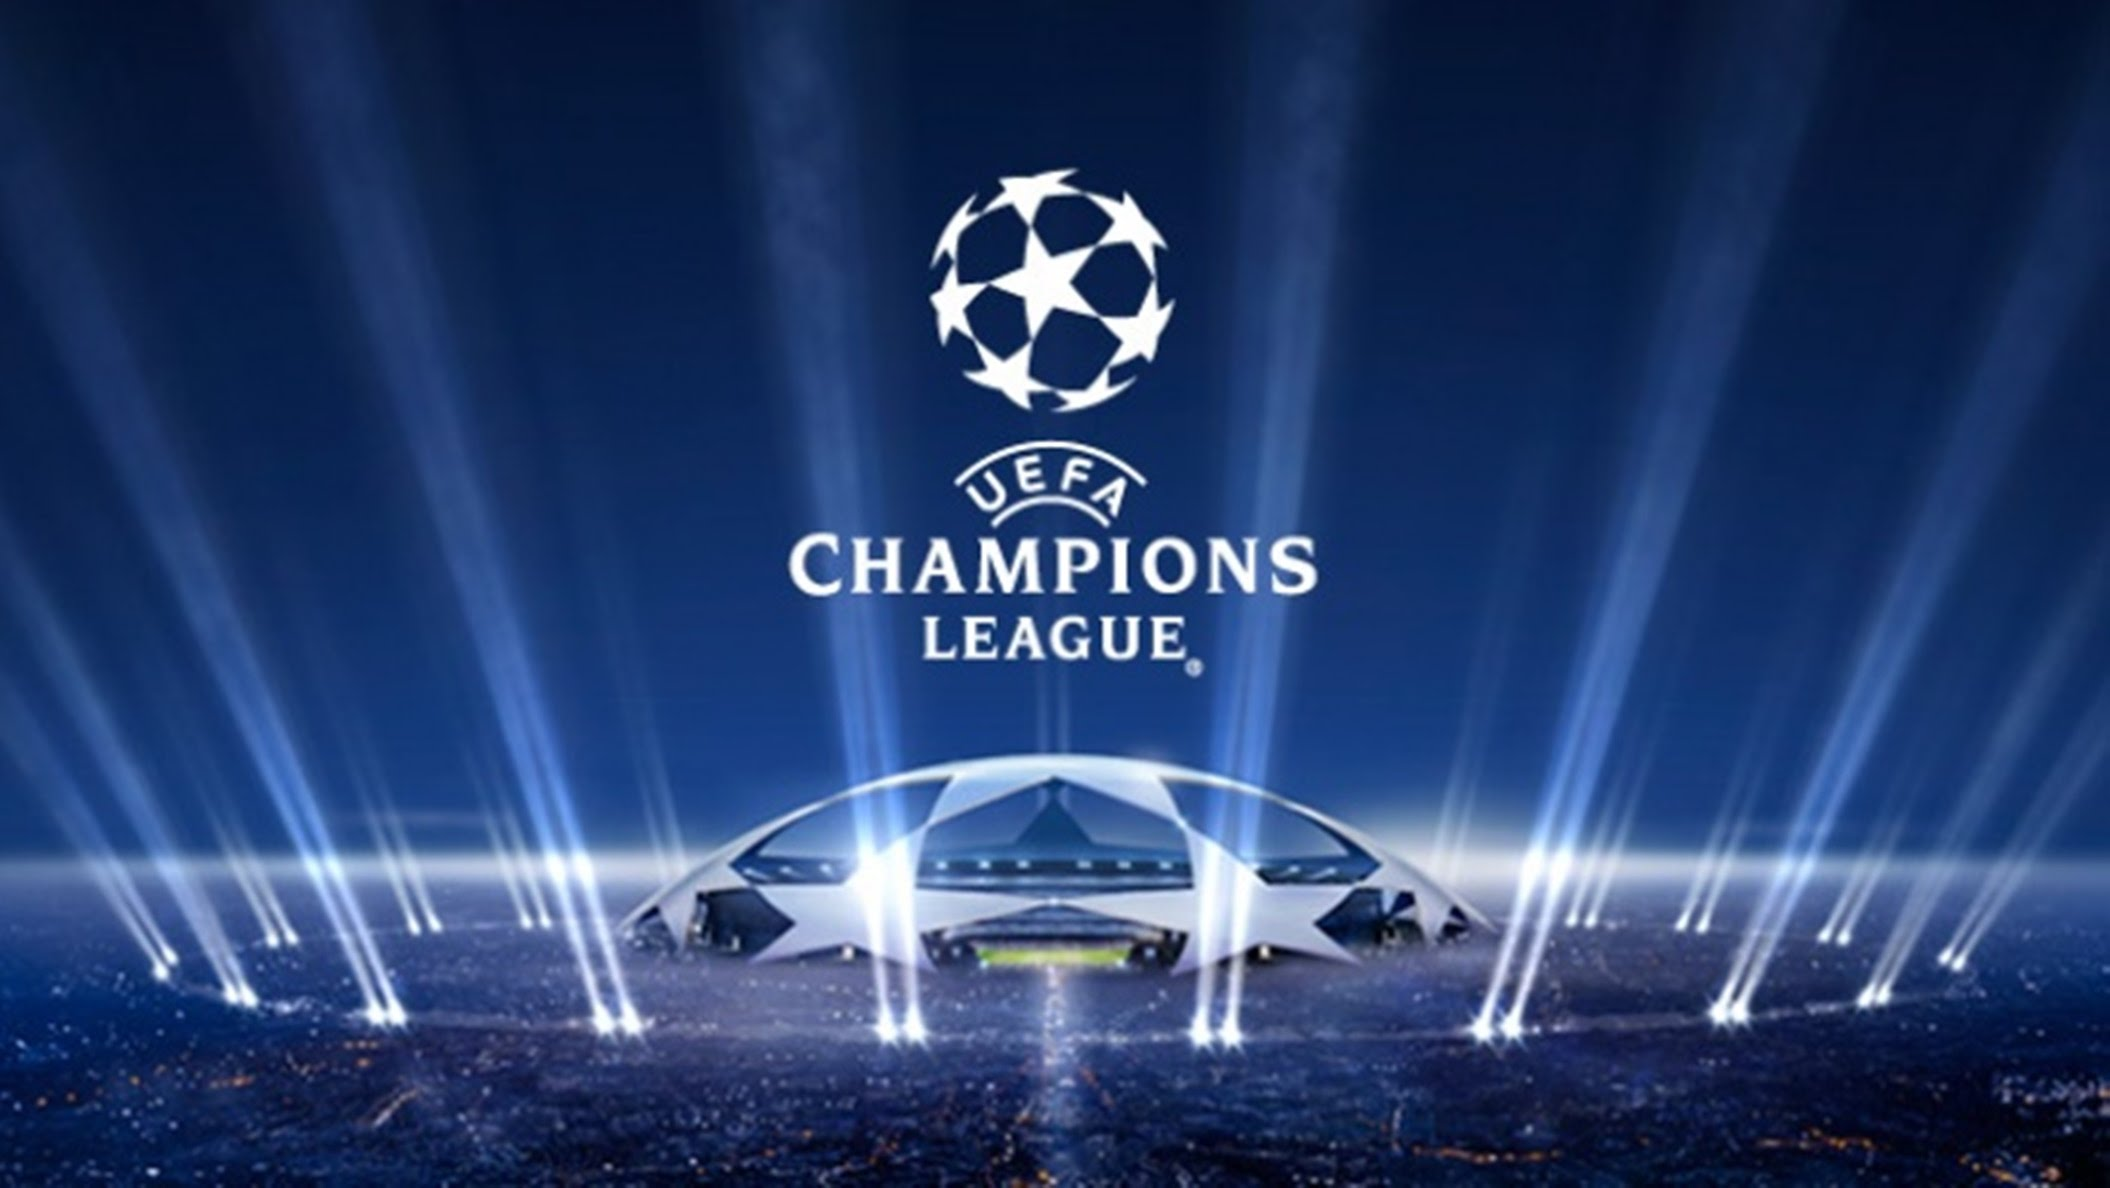

### Step 1: Data Preparation

In this step, we will load the data and cleanse it if needed. We will also examine the columns for any missing values and fill them.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('key_stats.csv')

# Converting distance_covered to float
data['distance_covered'] = pd.to_numeric(data['distance_covered'], errors='coerce')

# Checking for missing values
print(data.isnull().sum())

print(data.head())

player_name         0
club                0
position            0
minutes_played      0
match_played        0
goals               0
assists             0
distance_covered    2
dtype: int64
       player_name         club    position  minutes_played  match_played  \
0         Courtois  Real Madrid  Goalkeeper            1230            13   
1  Vinícius Júnior  Real Madrid     Forward            1199            13   
2          Benzema  Real Madrid     Forward            1106            12   
3           Modrić  Real Madrid  Midfielder            1077            13   
4     Éder Militão  Real Madrid    Defender            1076            12   

   goals  assists  distance_covered  
0      0        0              64.2  
1      4        6             133.0  
2     15        1             121.5  
3      0        4             124.5  
4      0        0             110.4  


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   player_name       747 non-null    object 
 1   club              747 non-null    object 
 2   position          747 non-null    object 
 3   minutes_played    747 non-null    int64  
 4   match_played      747 non-null    int64  
 5   goals             747 non-null    int64  
 6   assists           747 non-null    int64  
 7   distance_covered  745 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 46.8+ KB


In [3]:
# Check for any missing values after conversion
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

# filling the missing values in distance_covered to 0
if missing_values.any():
    data['distance_covered'].fillna(0, inplace=True)

Missing values in each column:
 player_name         0
club                0
position            0
minutes_played      0
match_played        0
goals               0
assists             0
distance_covered    2
dtype: int64


### Step 2: Data Analysis

In this step we will analyze the distribution of individual variables such as goals, assists, minutes played, etc. using box plots and examine relationships between goals and other variables like assists, minutes played, and distance covered, using scatter plots and correlation matrices. Then we will group the data by player positions and compare goal-scoring and assists statistics across different positions.

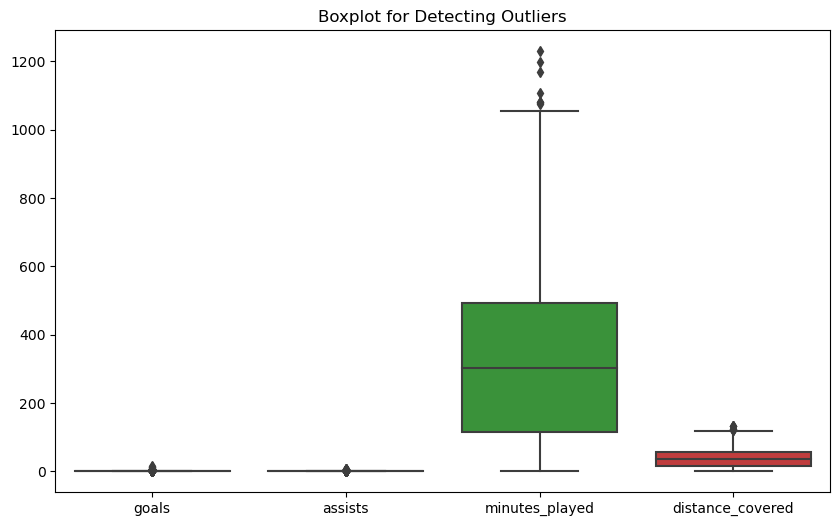

In [4]:
# Boxplot to visualize outliers in key numeric fields
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['goals', 'assists', 'minutes_played', 'distance_covered']])
plt.title('Boxplot for Detecting Outliers')
plt.show()




We can see that several outliers are available for these four columns, but they may not be true outliers because there are many players in the dataset those played all of the matches and had a substantial number of goals, assists, and covered more distance than others or vice versa.



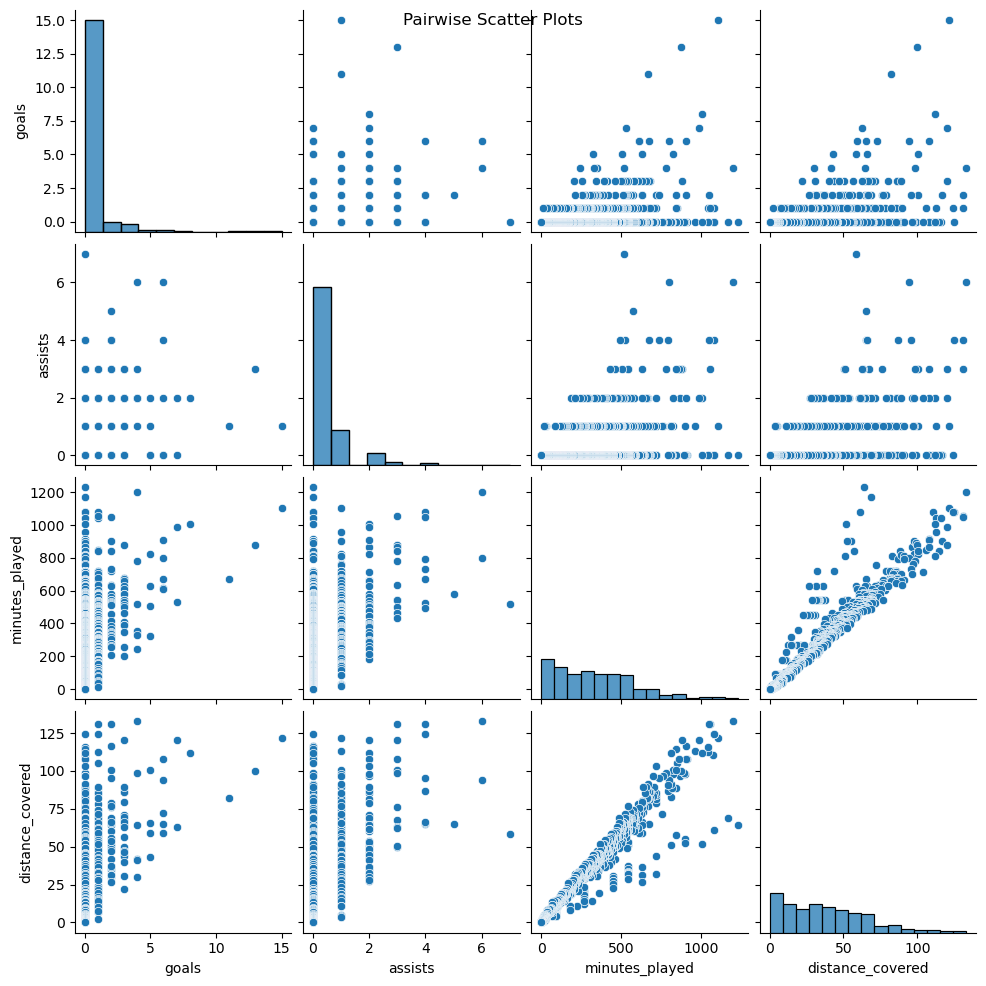

,goals,assists,minutes_played,distance_covered
goals,1.000000,0.355601,0.338638,0.368398
assists,0.355601,1.000000,0.377284,0.430474
minutes_played,0.338638,0.377284,1.000000,0.946440
distance_covered,0.368398,0.430474,0.946440,1.000000


In [5]:
# Pairwise relationships
sns.pairplot(data[['goals', 'assists', 'minutes_played', 'distance_covered']], kind='scatter')
plt.suptitle('Pairwise Scatter Plots')
plt.show()

# Correlation
correlation_matrix = data[['goals', 'assists', 'minutes_played', 'distance_covered']].corr()
correlation_matrix



The scatter plot and correlation matrix show that distance covered has a positive relationship with minutes played, which makes it obvious because the more minutes a player plays, more is the distance the player can cover.



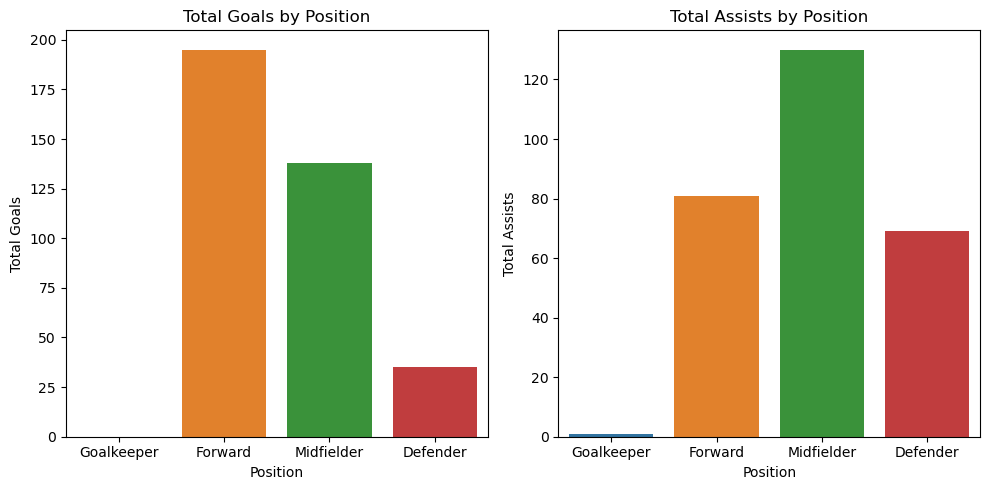

In [6]:
# goals and assists by position
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.barplot(x='position', y='goals', data=data, estimator=sum, errorbar=None)
plt.title('Total Goals by Position')
plt.xlabel('Position')
plt.ylabel('Total Goals')

plt.subplot(1, 2, 2)
sns.barplot(x='position', y='assists', data=data, estimator=sum, errorbar=None)
plt.title('Total Assists by Position')
plt.xlabel('Position')
plt.ylabel('Total Assists')

plt.tight_layout()
plt.show()



As expected, forwards scored the majority of goals, while midfielders provided maximum assists.


### Step 3: Linear Regression

In this step step, our goal is to train a model using linear regression which can predict goals. As we have already seen that goals have a moderate relation with the available columns, we will introduce **new features**, so that they can be used on our model and increase the accuracy score.

In [7]:
# creating new features
data['goals_per_match'] = data['goals'] / data['match_played']
data['assists_per_match'] = data['assists'] / data['match_played']
data['minutes_per_match'] = (data['minutes_played'] / data['match_played']).astype(int)

# new features
print(data[['player_name', 'goals_per_match', 'assists_per_match', 'minutes_per_match']].head())


       player_name  goals_per_match  assists_per_match  minutes_per_match
0         Courtois         0.000000           0.000000                 94
1  Vinícius Júnior         0.307692           0.461538                 92
2          Benzema         1.250000           0.083333                 92
3           Modrić         0.000000           0.307692                 82
4     Éder Militão         0.000000           0.000000                 89


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Selecting features and target
features = ['assists', 'minutes_played', 'distance_covered', 'goals_per_match', 'assists_per_match', 'minutes_per_match']
X = data[features]
y = data['goals']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


MSE: 0.5967839576166912
R-squared: 0.8288687927409315




Our linear regression model explains about 82.89% of the variance in the goals scored, which is quite strong for such models. The MSE suggests that the model's predictions are relatively close to the actual data, though there is still some error to consider.

Now, we will try to improve it using Polynomial regression model.



In [9]:
from sklearn.preprocessing import PolynomialFeatures

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Split the transformed data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train the model on the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, y_train)

# Predict and evaluate
y_pred_poly = model_poly.predict(X_test_poly)
print("Polynomial MSE:", mean_squared_error(y_test, y_pred_poly))
print("Polynomial R-squared:", r2_score(y_test, y_pred_poly))


Polynomial MSE: 0.0209905496397258
Polynomial R-squared: 0.993980840042646




The polynomial regression model has significantly improved both in terms of MSE and R-squared compared to the linear model. An R-squared of 99.27% indicates that the model captures almost all the variability in the response variable with very little error, showing that including interaction terms and non-linear transformations has 
captured much more complexity in the dataset.



In [10]:
from sklearn.feature_selection import RFE

# Initialize the RFE model, using the linear regression estimator
selector = RFE(model, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

# Print selected features
selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)

# Creating a new model using only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train a new model
model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train)

# Predict and evaluate with selected features
y_pred_selected = model_selected.predict(X_test_selected)
print("RFE MSE:", mean_squared_error(y_test, y_pred_selected))
print("RFE R-squared:", r2_score(y_test, y_pred_selected))


Selected features: Index(['assists', 'goals_per_match', 'assists_per_match'], dtype='object')
RFE MSE: 0.6284356304151495
RFE R-squared: 0.8197924948467977




The RFE method focused on simplifying the model by selecting only three features that are most predictive of the number of goals scored. While the R-squared is slightly lower than the full linear model, it still explains a substantial amount of variance using fewer features, which can be advantageous for understanding the most impactful factors and for making the model more interpretable and less prone to overfitting in different or larger datasets.



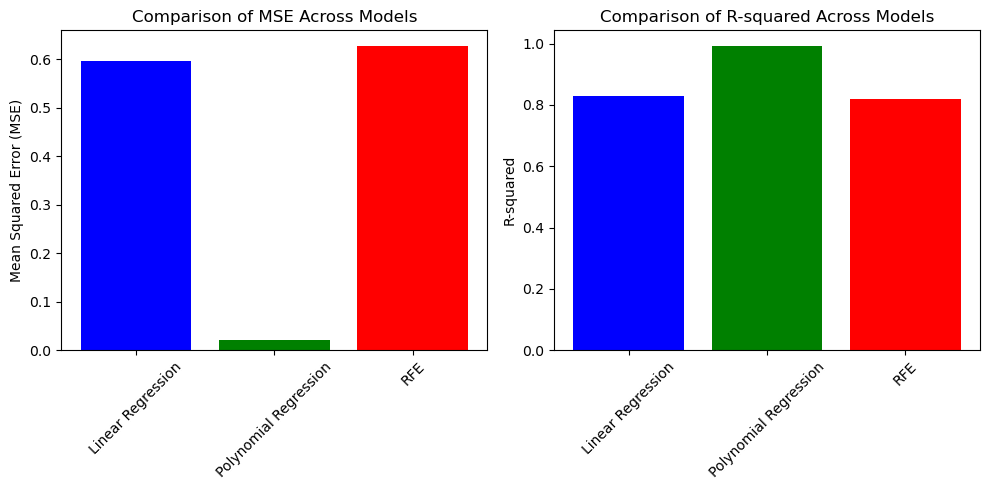

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
models = ['Linear Regression', 'Polynomial Regression', 'RFE']
mse_values = [0.5965273424279551, 0.0209905496397258, 0.6284356304151495]
r_squared_values = [0.828942378611478, 0.993980840042646, 0.8197924948467977]

# Creating a bar plot for MSE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color=['blue', 'green', 'red'])
plt.title('Comparison of MSE Across Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.xticks(rotation=45)

# Creating a bar plot for R-squared
plt.subplot(1, 2, 2)
plt.bar(models, r_squared_values, color=['blue', 'green', 'red'])
plt.title('Comparison of R-squared Across Models')
plt.ylabel('R-squared')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Step 4: Logistic Regression

In this step, we will train a Logistic regression model which will predict whether a player will score above or below the median number of goals and validate the models using cross validation.

To achieve that first we will create a new binary column called 'above_median_goals'.


In [12]:
# Calculate the median of the 'goals' column
median_goals = data['goals'].median()

# Create a new binary target variable based on the median
data['above_median_goals'] = (data['goals'] > median_goals).astype(int)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define features (X) and the new target (y_class)
X = data[features]
y_class = data['above_median_goals']

# Splitting the data into training and testing sets
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=142)

# Initializing and training the logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train_class)

# Making predictions on the training data
y_train_pred_class = classifier.predict(X_train)

# Making predictions on the test data
y_test_pred_class = classifier.predict(X_test)

# Calculating accuracies
train_accuracy = accuracy_score(y_train_class, y_train_pred_class)
test_accuracy = accuracy_score(y_test_class, y_test_pred_class)

# Evaluation
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Train Accuracy: 0.9112227805695142
Test Accuracy: 0.92


The model achieved an impressive 91.12% accuracy on the training data, which means it learned well from the examples it was trained on. Similarly, it scored 91.33% on the test data, which shows that it can reliably predict on new, unseen data. The close match between these two figures suggests that the model is both robust and generalizable, avoiding common pitfalls like overfitting, where a model might perform well on training data but poorly on new data.

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
classifier = LogisticRegression(max_iter=1000)

# Perform cross-validation
cv_scores = cross_val_score(classifier, X, y_class, cv=5, scoring='accuracy')

# Print cross-validation results
print("CV Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


CV Accuracy Scores: [0.62666667 0.94       0.85234899 0.8590604  0.89932886]
Mean CV Accuracy: 0.8354809843400448


The accuracy scores from the cross-validation—62.67%, 92.67%, 83.89%, 85.91%, and 89.93%—show significant variation. This variability suggests that while the model can perform exceptionally well under certain conditions, its performance can markedly drop under others. The average of these scores is approximately 83.01%, which is lower than the model’s initial training and test accuracies.

### Step 5: K-Nearest Neighbour Classification

In this step, we will classify players into different categories based on their performances using KNN clustering algorithim and tune the hyper-parameter K in KNN, visualize the results, and explain how K influences the prediction performance.

To achieve this, first we will create a new column named 'performance_category' and set the category based on conditions to 'Key Player', 'Regualr Player' and 'Occasional Player'.

As other positions do not have as many opportunities to score goals as forwards, we will take the goal_per_match, assists, and minutes_per_match columns and set up thresholds to define the category in such a way so that we can identify crucial players from all positions.

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

position_mapping = {
    'Goalkeeper': 1,
    'Defender': 2,
    'Midfielder': 3,
    'Forward': 4
}

data['position_ordinal'] = data['position'].map(position_mapping)

# Function to categorize players based on available metrics
def categorize_performance(row):
    if row['position'] == 'Forward' and row['goals_per_match'] > 0.5:
        return 'Key Player'
    elif row['position'] == 'Midfielder' and row['assists_per_match'] > 0.4:
        return 'Key Player'
    elif row['position'] == 'Defender' and row['minutes_per_match'] >= 80:
        return 'Key Player'
    elif row['position'] == 'Goalkeeper' and row['minutes_per_match'] >= 88:
        return 'Key Player'
    elif row['minutes_per_match'] >= 60:
        return 'Regular Player'
    else:
        return 'Occasional Player'

# Apply the categorization function
data['performance_category'] = data.apply(categorize_performance, axis=1)

# Select features
features = ['position_ordinal', 'goals_per_match', 'assists_per_match', 'minutes_per_match']
X = data[features]
y = data['performance_category']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Evaluate the Model
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9133333333333333




We have achieved an impressive score of 91.33%. Now, we will validate our model using cross validation.




In [16]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)

# Perform cross-validation
cv_scores = cross_val_score(knn, X_scaled, y, cv=10)

print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation in CV Accuracy:", cv_scores.std())


Cross-Validation Accuracy Scores: [0.88       0.92       0.92       0.94666667 0.96       0.94666667
 0.94666667 0.95945946 0.83783784 0.97297297]
Mean CV Accuracy: 0.9290270270270271
Standard Deviation in CV Accuracy: 0.039537661617065886




The cross-validation results we've gotten are very promising, showing high accuracy across the folds with a mean cross-validation accuracy of about 92.90% and a low standard deviation. This confirms the robustness and generalizability of our KNN model.



Fitting 10 folds for each of 30 candidates, totalling 300 fits


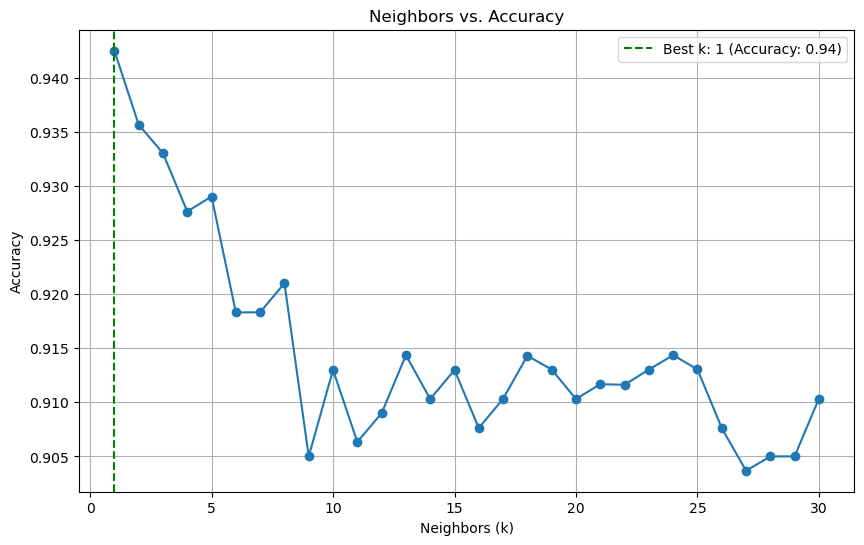

Best K: 1
Best Score: 0.9425045045045044


In [17]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the parameter grid for 'k'
param_grid = {'n_neighbors': range(1, 31)}

# Setup GridSearchCV
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_scaled, y)

# Extracting the results
k_values = grid_search.cv_results_['param_n_neighbors']
mean_test_scores = grid_search.cv_results_['mean_test_score']

# Best parameters and best score
best_k = grid_search.best_params_['n_neighbors']
best_score = grid_search.best_score_

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_test_scores, marker='o')
plt.xlabel('Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Neighbors vs. Accuracy')
plt.axvline(best_k, color='g', linestyle='--', label=f'Best k: {best_k} (Accuracy: {best_score:.2f})')
plt.legend()
plt.grid(True)
plt.show()

print("Best K:", best_k)
print("Best Score:", best_score)




In a K-Nearest Neighbors (KNN) classifier, selecting the number of neighbors (k) is crucial for optimal model performance. We can see that the accuracy peaks at k=1, indicating that minimal neighbors capture essential data patterns effectively. However, as k increases, the model's accuracy initially decreases, suggesting an overgeneralization and potential underfitting. Interestingly, the plot shows a resurgence in accuracy for larger k values beyond 8, indicating that the model begins to stabilize and better generalize, possibly by capturing broader data trends that aren't apparent with fewer neighbors. This behavior underscores the need to balance between overfitting with too few neighbors and beneficial generalization with more extensive neighborhoods.

